# **Climate Hazard Index Map with Google Earth Engine Datasets**

### *READ ME*

### Install Earth Engine API, geemap, and eemont

Before we start, we have to install earth engine api and geemap. The **geemap** Python package can implement several methods for interacting with Earth Engine data layers, such as `Map.addLayer()`, `Map.setCenter()`, and `Map.centerObject()`. To install geemap, we can use the following script:

`!pip install geemap`

The script will be automatically install dependence tools including earthengine-api, earthengine-api, etc. If it installed, it would check the packages.

**Please take note** that Google Colab now can support `ipyleaflet` (source). We can install it with the following script `!pip install ipyleaflet` and `import ipyleaflet` to use in Google Colab and Jupyter Notebook.

For `geemap`, `import geemap.eefolium` is used if you're utilizing geemap with Google Colab. Use `import geemap`, which offers more functionalities for capturing user input, if you're using geemap with Binder or a local Jupyter notebook server.

After we install `geemap` or `ipyleaflet`, we can install `eemont`. [eemont](https://github.com/davemlz/eemont) is a Python package that has functionality like cloud masking and spectral index calculation to Earth Engine classes.


In [ ]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install ipyleaflet

!jupyter nbextension enable --py --sys-prefix ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-leaflet/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
!pip install eemont

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 7.5 MB/s 
  Created wheel for eemont: filename=eemont-0.3.5-py3-none-any.whl size=123958 sha256=3fd06914850a602ab90dd1d67338fe4f74b4ce82d740dc2b15573823b2fd7460
  Stored in directory: /root/.cache/pip/wheels/c0/3d/27/325810b8742c827ff16d02aa0dc55c70de38a1b0fec9eb01c3
Successfully built eemont


## **Fire Weather Index Map with Google Earth Engine Datasets**
### 1. Upload object class for input and calculate FWI, and import it 

Before we create FWI Map, we have to prepare object class to prepare data input in FWI and also calculate FWI. Inputs of FWI use `input_fwi.py` and import `GFS_MAP`, while to calculate FWI we use `fwi_calculator.py` and import `FWICalculator`.

These calculation use NOAA/GFS0P25 data such as temperature, relative humidity, total rainfall, and wind. We calculate it by Equation Canadian Forest Fire Weather Index System.

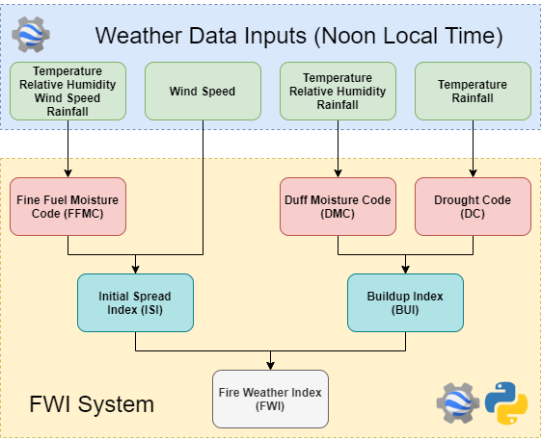

The FWI formula is:

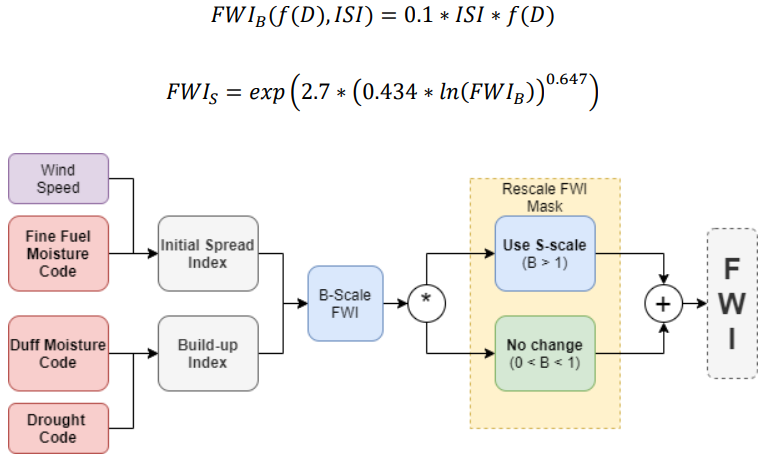

In [1]:
from input_fwi import GFS_MAP
from fwi_calculator import FWICalculator

After all installation, we import tools that is needed in calculation such as `ee`, `eemont`, `geemap`, `datetime`.
We have to authenticate and initialize earth engine to our account. So we can access the interactive map.

In [2]:
# Installs geemap package
import google.colab
import geemap.eefolium as geemap

# Authenticates and initializes Earth Engine
import ee
import eemont
import ipyleaflet
import datetime

ee.Authenticate()
ee.Initialize()

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# Authenticates and initializes Earth Engine
import geemap as geemap
import ee
import eemont
import ipyleaflet
import datetime

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AfgeXvvOlD38c8Vn3scroJ4bFytXoHtmxf3IcyUtWbQtnQVhXFiXWHzjgJA

Successfully saved authorization token.


### 2. Input Data and Create Layers

The default basemap for geemap is `Google Maps`. [Additional basemaps](https://github.com/giswqs/geemap/blob/master/geemap/basemaps.py) can be added using the `Map.add_basemap()` function. 
Create the color palette for map by setting min, max, and palette we want to use.
Additional layer can we add to map using the `geemap.Map.addLayer(map we want to use)`.

In [3]:
#Input date, timezone and boundary of data
date = datetime.date.today() - datetime.timedelta(days=1)
timezone = 'Asia/Jakarta'
boundary = ee.Geometry.BBox(90, -15.0, 150.0, 15.0)

#Calculate FWI
inputs = GFS_MAP(date, timezone, boundary)
calculator = FWICalculator(date, inputs)
calculator.set_previous_codes()
fwi = calculator.compute()

#Create color palette
vis_params = {
    'min' : 0,
    'max' : 64,
    'palette' : ['blue', 'green', 'yellow', 'red']
}

#Select boundary of map that will show in Map
#For Indonesia boundary, we select from FAO dataset
indonesia = ee.FeatureCollection('FAO/GAUL/2015/level0') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Indonesia'))
fwi_map = fwi.clip(indonesia)

In [22]:
Map = geemap.Map(center=[0, 120], zoom= 4)
Map.addLayer(fwi_map, vis_params, 'FWI');
Map

Map(center=[0, 120], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

### 3. Export FWI to Local Drive

We can export the map to our local drive. Create path directory of downloaded data and file name.
Export it using `geemap.ee_export_image`.

In [5]:
#Create geometry boundary to export the image
indo_shape = indonesia.geometry()

In [18]:
regional = ee.Geometry.Polygon(
        [[[101.53330135439737, -1.7103200759272839],
          [101.53330135439737, -2.5227468940431086],
          [102.57700252627237, -2.5227468940431086],
          [102.57700252627237, -1.7103200759272839]]]);

In [6]:
#Import os to input output path and fime name
import os
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'FWI.tif')

In [7]:
#Export map
geemap.ee_export_image(fwi, filename=filename, scale=1500, region=indo_shape, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Nuraini\Downloads\FWI.tif


## Standardized Precipitation Index (SPI) Map by Google Earth Engine

### 1. Calculate SPI from CHIRPS Datasets

The Standard Precipitation Index (SPI) is a relatively new drought index based only on precipitation. It's an index based on the probability of precipitation for any time scale. For SPI, we use CHIRPS dataset and calculate SPI using formula:
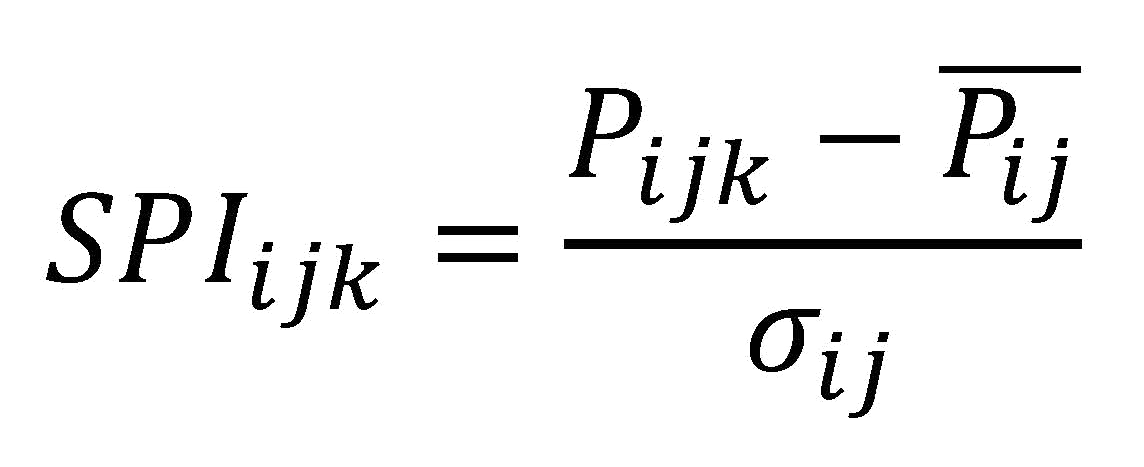
Step by step of creating SPI in Google Earth Engine can be read in [this](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-drought-monitoring-spi/step-by-step).
Here we will calculate monthly SPI. Range of SPI is between `-2` and `2`.

In [27]:
### set time of monthly length
start = 31+28

#set time frame of running and download
start_date = '1981-01-01'
end_date = '2021-12-31'

start_Download = '2022-01-01'
end_Download = '2022-11-01'

#set resolution of our map
resolution = 500

#Long term average (LTA) can be generated directly from the pre-calculated Rainfall
lta = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filter(ee.Filter.dayOfYear(start, start + 31)).filterDate(start_date, end_date)

lta_mean = lta.select('precipitation').mean().clip(indonesia)
lta_std = lta.reduce(ee.Reducer.stdDev()).clip(indonesia)

#the latest rainfall
latest = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filter(ee.Filter.dayOfYear(start, start + 31)).filterDate(start_Download, end_Download)

rainfall_now = latest.select('precipitation').mean().clip(indonesia)


#Calculating rainfall anomaly and standardized precipitation index 
anomaly = rainfall_now.divide(lta_mean).multiply(100)
spi = rainfall_now.subtract(lta_mean).divide(lta_std)

#Define a colour table
red2blue = ['a60027','de3e2c','fa8b50','ffd485','e1e1e1','d3edf5','90c4de','5183bd','313694']
rainfall_viz = {min:0, max:25, 'palette': ['B8810B', 'CB8C08', 'FFE47E','FFF2C1', 'DAF7A6', 'D2FFFF', '2DE7E7', '00B9D6', '008BD6', '006399']}
rainanom_viz = {min:0, max:200, 'palette': red2blue}
spicolor = ['0000aa','0000ff','00aaff','00ffff','aaff55','ffffff','ffff00','fcd37f','ffaa00','e60000','730000']
spi_viz = {min:-2, max:2, 'palette': spicolor}



### 2. Show The SPI Map and Export to Local Drive

In [28]:
print('The observed time period of monthly SPI starts on ',
      start_date.format('YYYY-MM-dd'),
      'and ends on',
      end_date.format('YYYY-MM-dd'))

Map1 = geemap.Map(center=[0, 120], zoom= 4)

#Add the image to the map using both the color ramp and interval schemes.
Map1.addLayer(anomaly, rainanom_viz, 'Anomaly (Indo2022-LTA)')
Map1.addLayer(spi, spi_viz, 'SPI Indo2022')
Map1

The observed time period of monthly SPI starts on  1981-01-01 and ends on 2021-12-31


Map(center=[0, 120], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

In [ ]:
# Mengizinkan akses  ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Calculat

In [ ]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': fwi_map,
    'description': 'fwi_testing',
    'folder':'FWI_MAP',
    'scale': 10,
    'region': indonesia,
    'crs': 'EPSG:4326'
})
task.start()

In [ ]:
import geemap

In [ ]:
out_path = 
geemap.ee_export_image_collection(fwi_map,
                                  )

In [ ]:
geemap.ee_export_image_collection?

In [ ]:
#Showing map with layer FWI
Map = ipyleaflet.Map(center=(0, 120), zoom=5)
Map.add_layer(fwi_layer)
Map

Map(center=[0, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [ ]:
# Mengizinkan akses  ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Export the image, specifying scale and region.
from ipywidgets import  

AttributeError: ignored